## Competetion Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Acknowledgments

The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

https://github.com/liyenhsu/Kaggle-House-Prices/blob/master/Kernel_Ridge.ipynb

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer 

In [2]:
#read the dataset
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')
df = df_train.append(df_test , ignore_index = True)
df.shape

C:\Users\mansoorali_baig\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(2919, 81)

In [3]:
# divide the data into numerical ("quan") and categorical ("qual") features
quan = list( df_test.loc[:,df_test.dtypes != 'object'].drop('Id',axis=1).columns.values )
qual = list( df_test.loc[:,df_test.dtypes == 'object'].columns.values )

In [4]:
# Find out how many missing values there are for the quantitative and categorical features
hasNAN = df[quan].isnull().sum()
hasNAN = hasNAN[hasNAN > 0]
hasNAN = hasNAN.sort_values(ascending=False)
print(hasNAN)
print('--'*40)
hasNAN = df[qual].isnull().sum()
hasNAN = hasNAN[hasNAN > 0]
hasNAN = hasNAN.sort_values(ascending=False)
print(hasNAN)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64
--------------------------------------------------------------------------------
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Exterior1st        1
SaleType           1
Exterior2nd        1
KitchenQual        1
Electrical         1
dtype: int64


In [5]:
# Filling missing values for numerical features. Most of the NAN should mean that 
# the corresponding facillity/structure doesn't exist, so I use zero for most cases

df.LotFrontage.fillna(df.LotFrontage.median(), inplace=True)

# NAN should mean no garage. I temporarily use yr = 0 here. Will come back to this later. 
df.GarageYrBlt.fillna(0, inplace=True)

# Use zero
df.MasVnrArea.fillna(0, inplace=True)    
df.BsmtHalfBath.fillna(0, inplace=True)
df.BsmtFullBath.fillna(0, inplace=True)
df.GarageArea.fillna(0, inplace=True)
df.GarageCars.fillna(0, inplace=True)    
df.TotalBsmtSF.fillna(0, inplace=True)   
df.BsmtUnfSF.fillna(0, inplace=True)     
df.BsmtFinSF2.fillna(0, inplace=True)    
df.BsmtFinSF1.fillna(0, inplace=True)

In [7]:
# Filling missing values for categorical features
df.PoolQC.fillna('NA', inplace=True)
df.MiscFeature.fillna('NA', inplace=True)    
df.Alley.fillna('NA', inplace=True)          
df.Fence.fillna('NA', inplace=True)         
df.FireplaceQu.fillna('NA', inplace=True)    
df.GarageCond.fillna('NA', inplace=True)    
df.GarageQual.fillna('NA', inplace=True)     
df.GarageFinish.fillna('NA', inplace=True)   
df.GarageType.fillna('NA', inplace=True)     
df.BsmtExposure.fillna('NA', inplace=True)     
df.BsmtCond.fillna('NA', inplace=True)        
df.BsmtQual.fillna('NA', inplace=True)        
df.BsmtFinType2.fillna('NA', inplace=True)     
df.BsmtFinType1.fillna('NA', inplace=True)     
df.MasVnrType.fillna('None', inplace=True)   
df.Exterior2nd.fillna('None', inplace=True) 

# These are general properties that all houses should have, so NANs probably 
# just mean the values were not recorded. I therefore use "mode", the most 
# common value to fill in
df.Functional.fillna(df.Functional.mode()[0], inplace=True)       
df.Utilities.fillna(df.Utilities.mode()[0], inplace=True)          
df.Exterior1st.fillna(df.Exterior1st.mode()[0], inplace=True)        
df.SaleType.fillna(df.SaleType.mode()[0], inplace=True)                
df.KitchenQual.fillna(df.KitchenQual.mode()[0], inplace=True)        
df.Electrical.fillna(df.Electrical.mode()[0], inplace=True)    

# MSZoning should highly correlate with the location, so I use the mode values of individual 
# Neighborhoods
for i in df.Neighborhood.unique():
    if df.MSZoning[df.Neighborhood == i].isnull().sum() > 0:
        df.loc[df.Neighborhood == i,'MSZoning'] = \
        df.loc[df.Neighborhood == i,'MSZoning'].fillna(df.loc[df.Neighborhood == i,'MSZoning'].mode()[0])


In [8]:
# These categorical features are "rank", so they can be transformed to 
# numerical features
df.Alley = df.Alley.map({'NA':0, 'Grvl':1, 'Pave':2})
df.BsmtCond =  df.BsmtCond.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.BsmtExposure = df.BsmtExposure.map({'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df.BsmtQual = df.BsmtQual.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.ExterCond = df.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.ExterQual = df.ExterQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.FireplaceQu = df.FireplaceQu.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.Functional = df.Functional.map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8})
df.GarageCond = df.GarageCond.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.GarageQual = df.GarageQual.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.HeatingQC = df.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.KitchenQual = df.KitchenQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.LandSlope = df.LandSlope.map({'Sev':1, 'Mod':2, 'Gtl':3}) 
df.PavedDrive = df.PavedDrive.map({'N':1, 'P':2, 'Y':3})
df.PoolQC = df.PoolQC.map({'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df.Street = df.Street.map({'Grvl':1, 'Pave':2})
df.Utilities = df.Utilities.map({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4})

# Update my lists of numerical and categorical features
newquan = ['Alley','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual',
           'ExterCond','ExterQual','FireplaceQu','Functional','GarageCond',
           'GarageQual','HeatingQC','KitchenQual','LandSlope','PavedDrive','PoolQC',
           'Street','Utilities']
quan = quan + newquan 
for i in newquan: qual.remove(i)


# This is actually a categorical feature
df.MSSubClass = df.MSSubClass.map({20:'class1', 30:'class2', 40:'class3', 45:'class4',
                                   50:'class5', 60:'class6', 70:'class7', 75:'class8',
                                   80:'class9', 85:'class10', 90:'class11', 120:'class12',
                                   150:'class13', 160:'class14', 180:'class15', 190:'class16'})

# Keeping "YrSold" is enough
df=df.drop('MoSold',axis=1)

# Update my lists of numerical and categorical features
quan.remove('MoSold')
quan.remove('MSSubClass')
qual.append('MSSubClass')

For all the time variables, what matters should be the time duration. So I create three features: the age of the house (Age), the time duration since the remodel date (AgeRemod), and the age of the Garage (AgeGarage)

In [9]:
df['Age'] = df.YrSold - df.YearBuilt
df['AgeRemod'] = df.YrSold - df.YearRemodAdd
df['AgeGarage'] = df.YrSold - df.GarageYrBlt

# For the houses without a Garage, I filled the NANs with zeros, which makes AgeGarage ~ 2000
# Here I replace their AgeGarage with the maximum value among the houses with Garages
max_AgeGarage = np.max(df.AgeGarage[df.AgeGarage < 1000])
df['AgeGarage'] = df['AgeGarage'].map(lambda x: max_AgeGarage if x > 1000 else x)

# Some of the values are negative because the work was done after the house 
# was sold. In these cases, I change them to zero to avoid negative ages.
df.Age = df.Age.map(lambda x: 0 if x < 0 else x)
df.AgeRemod = df.AgeRemod.map(lambda x: 0 if x < 0 else x)
df.AgeGarage = df.AgeGarage.map(lambda x: 0 if x < 0 else x)

# drop the original time variables 
df=df.drop(['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt'],axis=1)

# update my list of numerical feature
for i in ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']: quan.remove(i)
quan = quan + ['Age','AgeRemod','AgeGarage']

C:\Users\mansoorali_baig\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


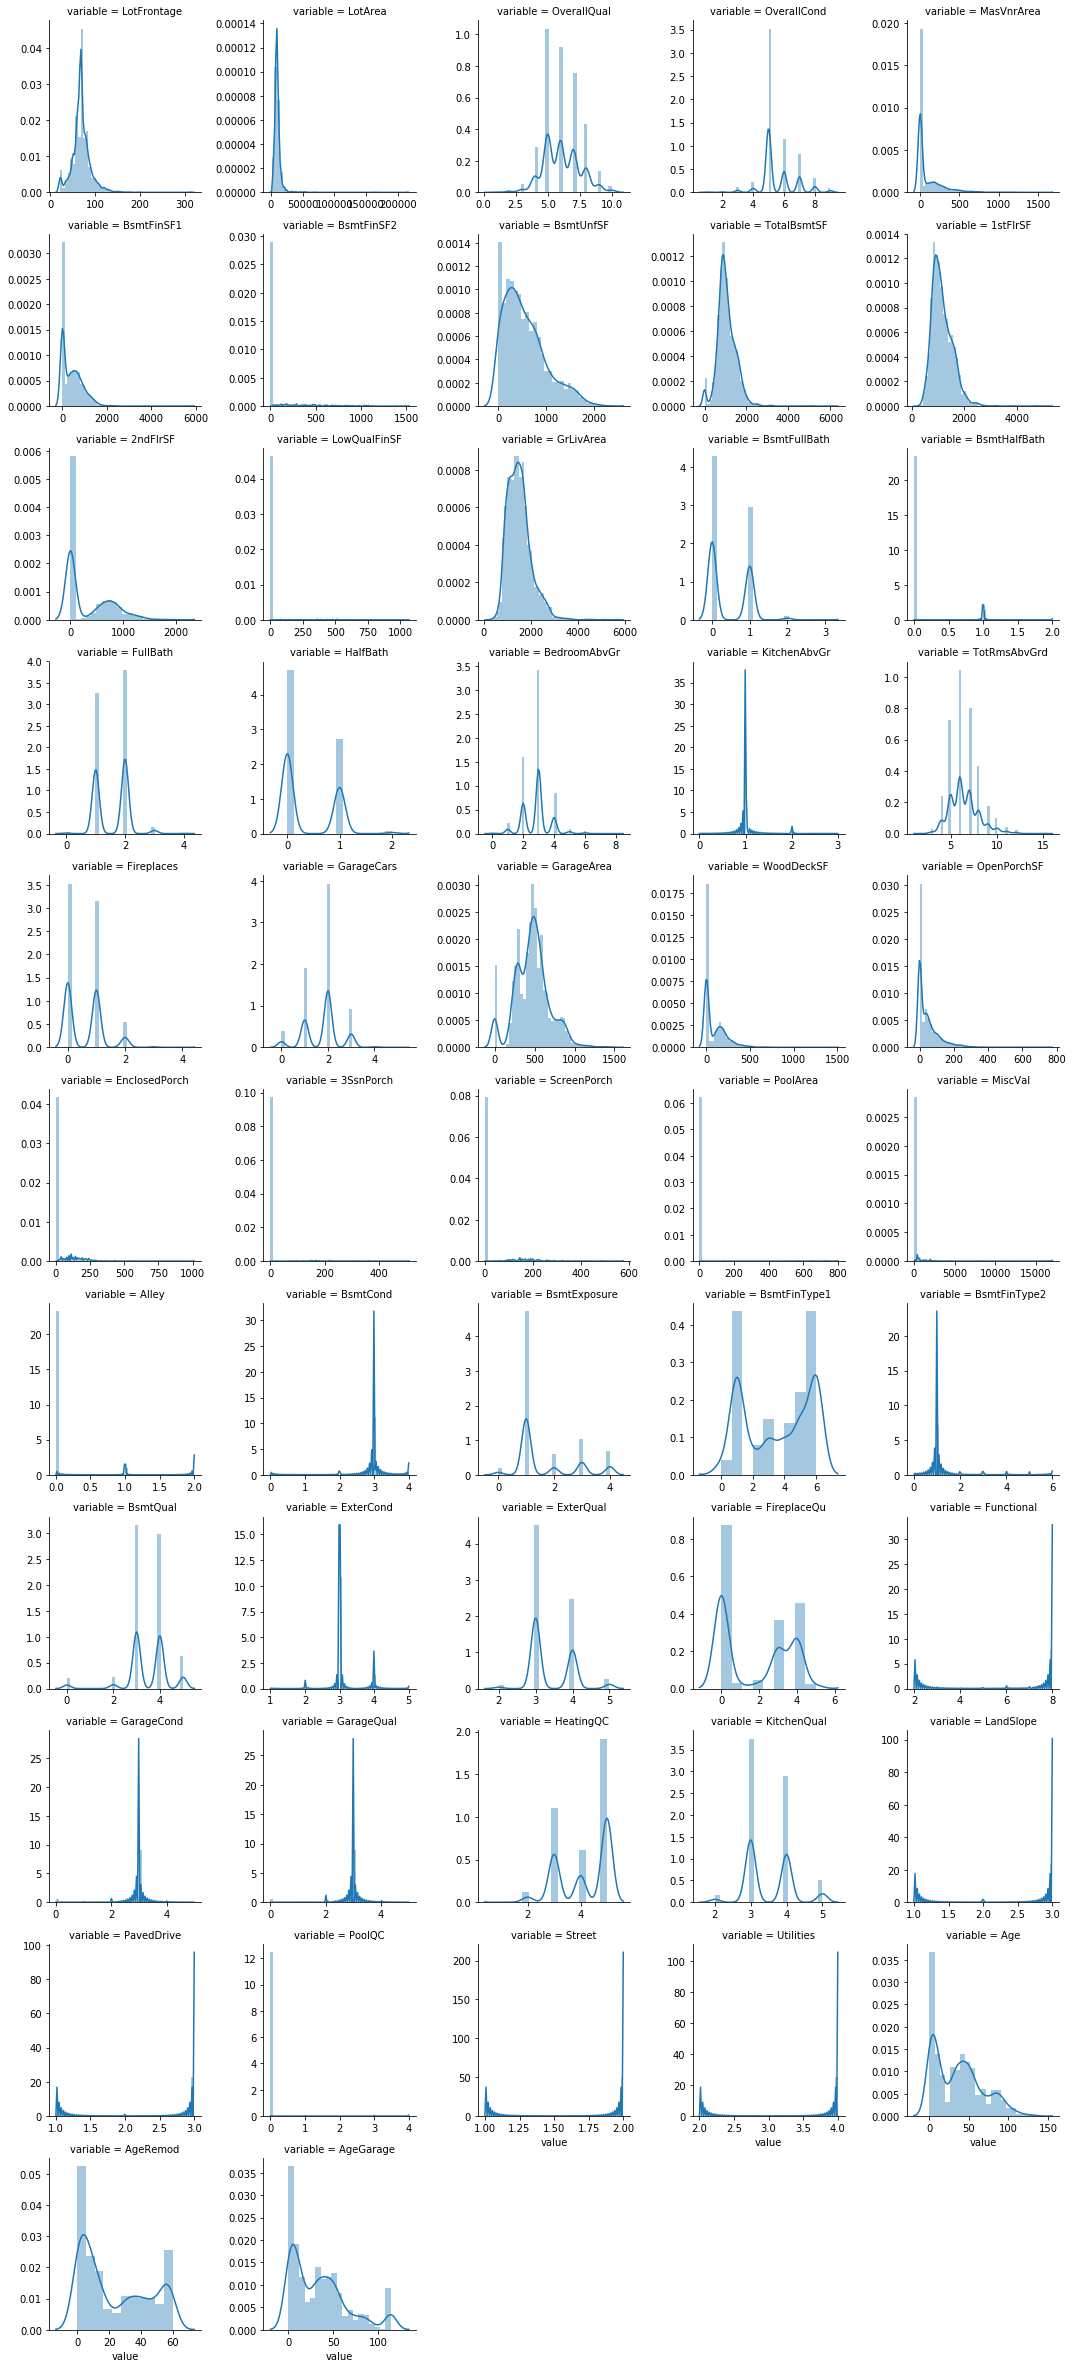

In [10]:
# visualize the distribution of each numerical feature
temp = pd.melt(df.drop('SalePrice',axis=1), value_vars=quan)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

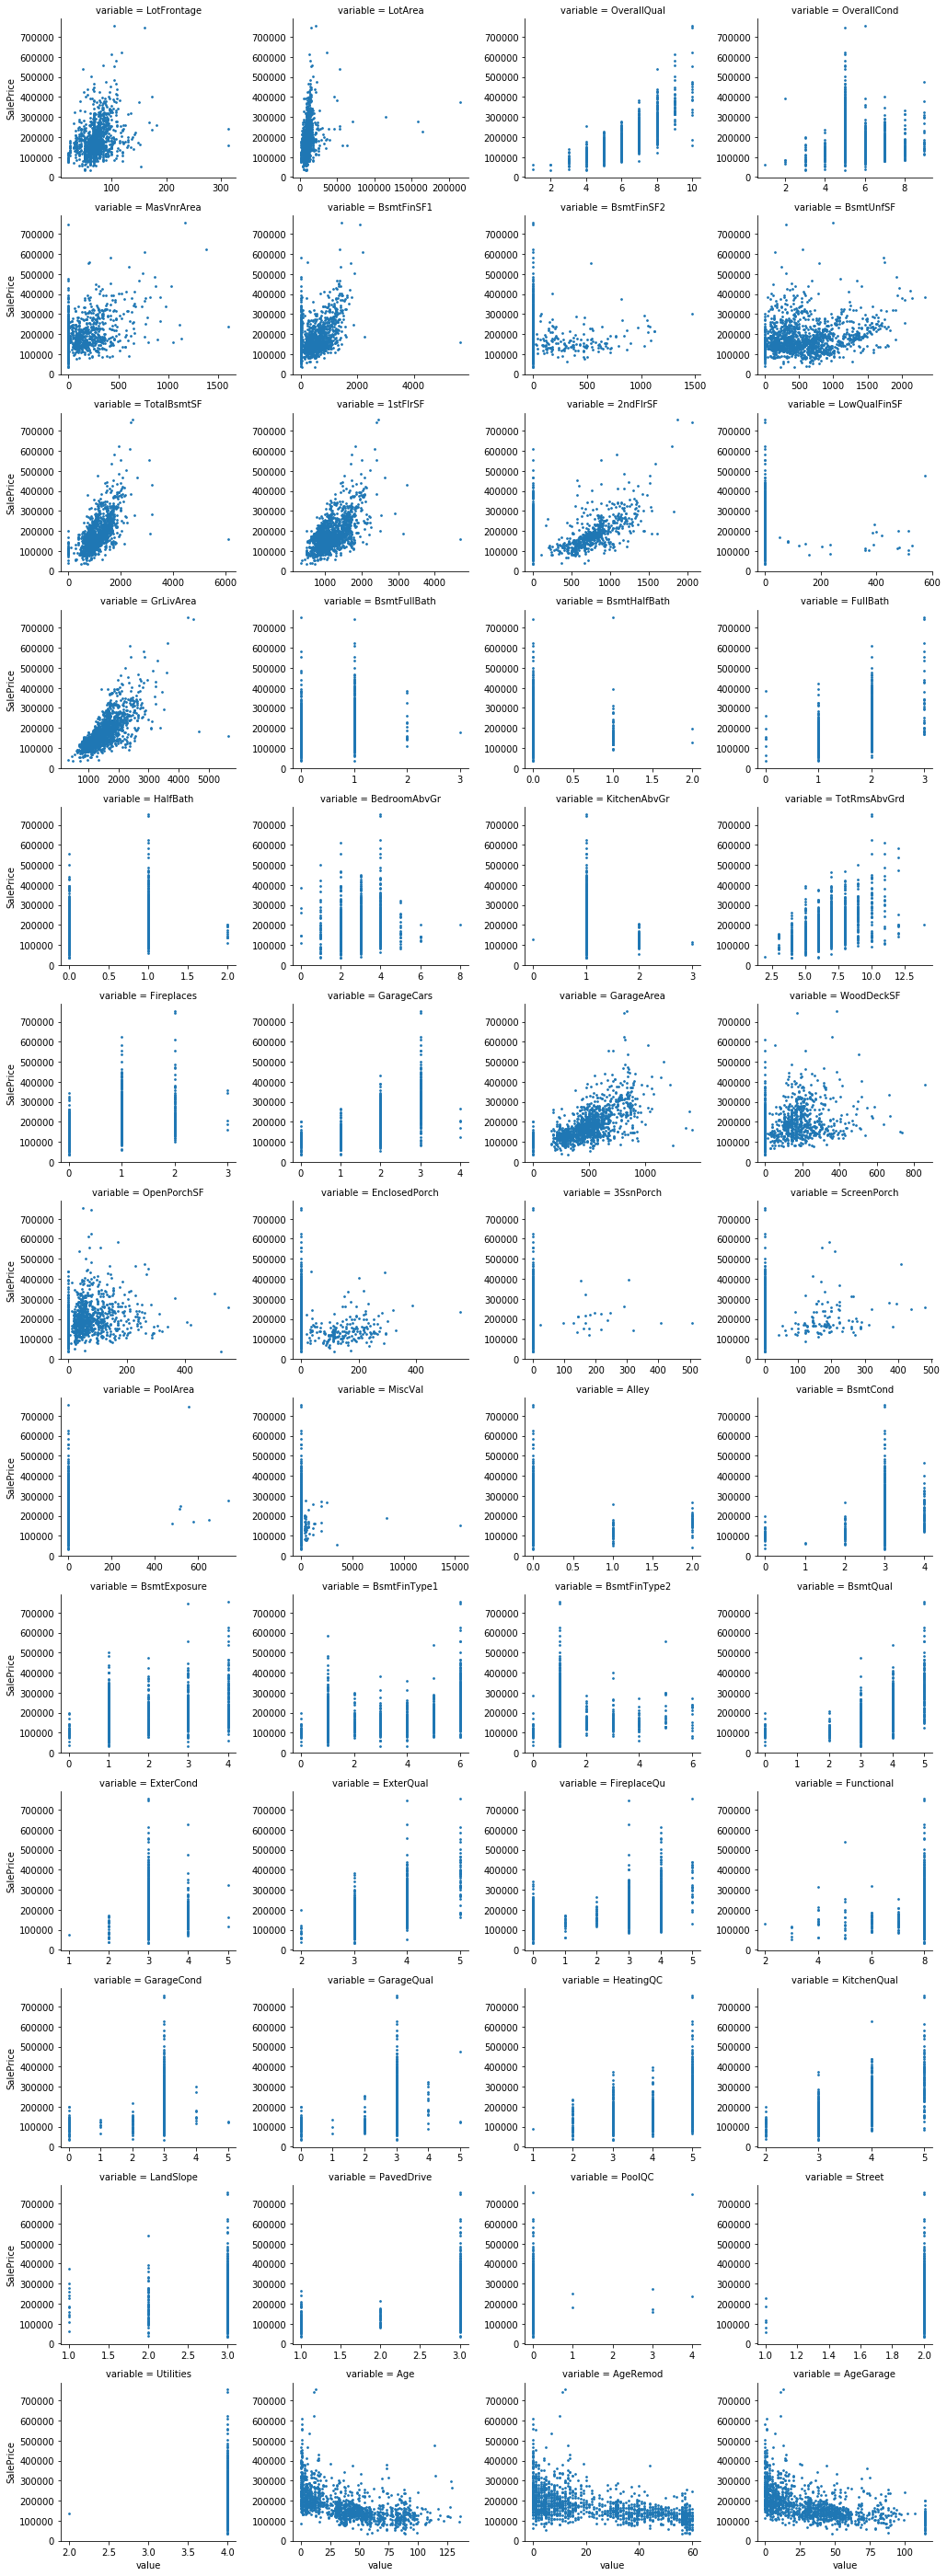

In [11]:
# scatter plots - to remove outlier
temp = pd.melt(df, id_vars=['SalePrice'],value_vars=quan)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=4 , height=3.0, 
                     aspect=1.2,sharex=False, sharey=False)
grid.map(plt.scatter, "value",'SalePrice', s=3)
plt.show()

In [12]:
# These are somewhat arbitrary 
index_drop = df.LotFrontage[df.LotFrontage > 300].index
index_drop = np.append(index_drop, df.LotArea[df.LotArea > 100000].index)
index_drop = np.append(index_drop, df.BsmtFinSF1[df.BsmtFinSF1 > 4000].index)
index_drop = np.append(index_drop, df.TotalBsmtSF[df.TotalBsmtSF > 6000].index)
index_drop = np.append(index_drop, df['1stFlrSF'][df['1stFlrSF'] > 4000].index)
index_drop = np.append(index_drop, df.GrLivArea[(df.GrLivArea > 4000) & (df.SalePrice < 300000)].index)
index_drop = np.unique(index_drop)

# make sure we only remove data from the training set
index_drop = index_drop[index_drop < 1460] 

df = df.drop(index_drop).reset_index(drop=True)
print("{} examples in the training set are dropped.".format(len(index_drop)))

7 examples in the training set are dropped.


In [13]:
# print the skewness of each numerical feature
from scipy.stats import skew
from scipy.stats import uniform

for i in quan:
    print(i+': {}'.format(round(skew(df[i]),2)))

LotFrontage: 0.76
LotArea: 3.6
OverallQual: 0.19
OverallCond: 0.57
MasVnrArea: 2.63
BsmtFinSF1: 0.98
BsmtFinSF2: 4.16
BsmtUnfSF: 0.92
TotalBsmtSF: 0.67
1stFlrSF: 1.26
2ndFlrSF: 0.86
LowQualFinSF: 12.07
GrLivArea: 1.07
BsmtFullBath: 0.62
BsmtHalfBath: 3.94
FullBath: 0.17
HalfBath: 0.69
BedroomAbvGr: 0.33
KitchenAbvGr: 4.3
TotRmsAbvGrd: 0.75
Fireplaces: 0.73
GarageCars: -0.22
GarageArea: 0.22
WoodDeckSF: 1.84
OpenPorchSF: 2.53
EnclosedPorch: 4.0
3SsnPorch: 11.36
ScreenPorch: 3.94
PoolArea: 17.67
MiscVal: 21.94
Alley: 4.13
BsmtCond: -3.6
BsmtExposure: 1.12
BsmtFinType1: -0.15
BsmtFinType2: 3.16
BsmtQual: -1.27
ExterCond: 1.31
ExterQual: 0.78
FireplaceQu: 0.18
Functional: -4.96
GarageCond: -3.38
GarageQual: -3.26
HeatingQC: -0.55
KitchenQual: 0.44
LandSlope: -4.98
PavedDrive: -2.97
PoolQC: 20.32
Street: -16.18
Utilities: -53.94
Age: 0.6
AgeRemod: 0.45
AgeGarage: 0.97


In [14]:
# transform those with skewness > 0.5
skewed_features = np.array(quan)[np.abs(skew(df[quan])) > 0.5]
df[skewed_features] = np.log1p(df[skewed_features])

C:\Users\mansoorali_baig\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


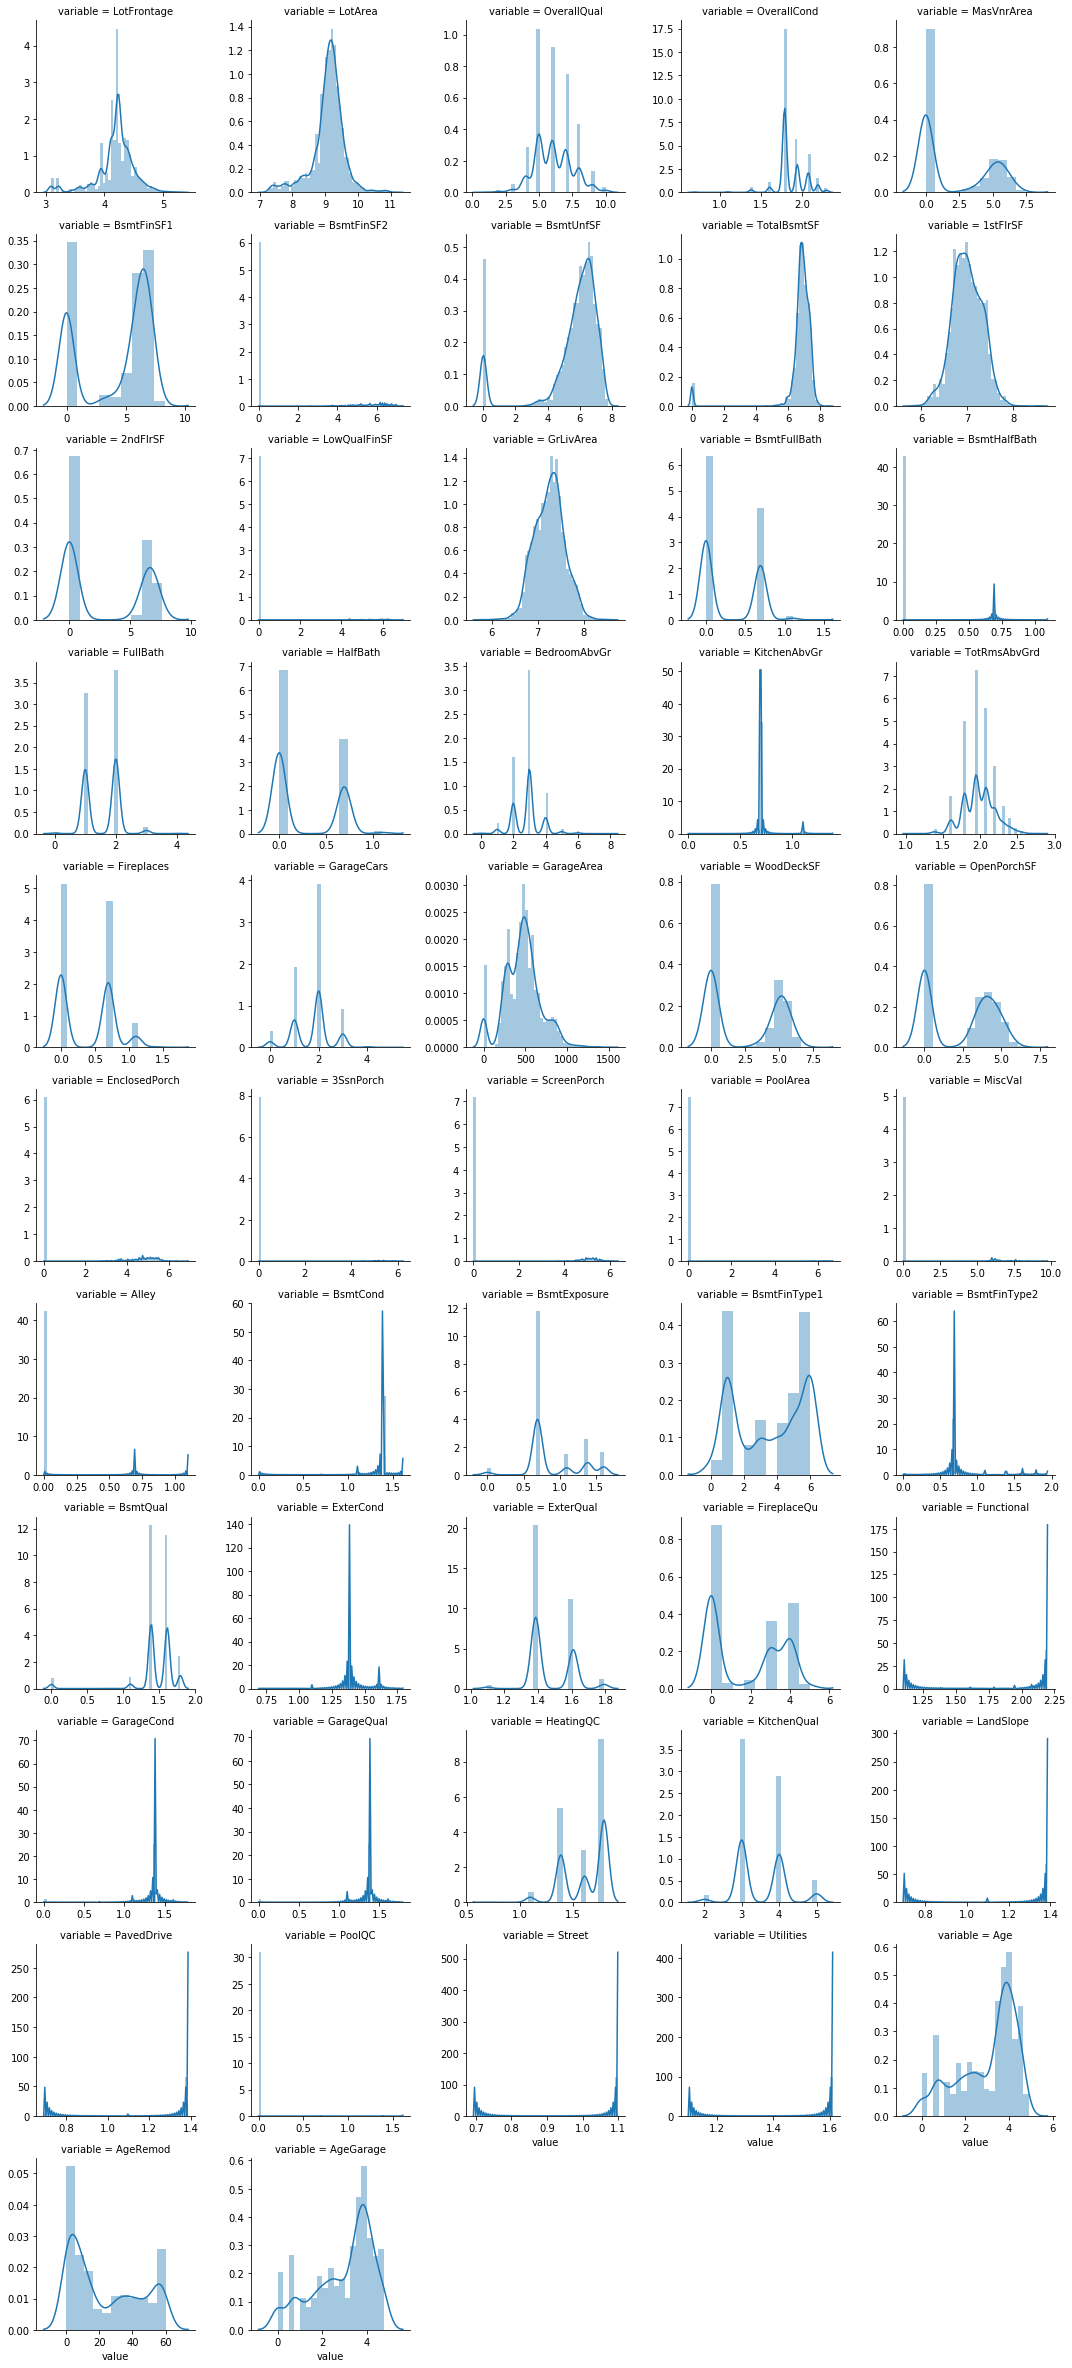

In [15]:
## visualize the distribution again
temp = pd.melt(df, value_vars=quan)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

In [17]:
# create of list of dummy variables that I will drop, which will be the last
# column generated from each categorical feature
dummy_drop = []
for i in qual:
    dummy_drop += [ i+'_'+str(df[i].unique()[-1]) ]

# create dummy variables
df = pd.get_dummies(df,columns=qual) 
# drop the last column generated from each categorical feature
df = df.drop(dummy_drop,axis=1)

In [18]:
X_train  = df[:-1459].drop(['SalePrice','Id'], axis=1)
y_train  = df[:-1459]['SalePrice']
X_test  = df[-1459:].drop(['SalePrice','Id'], axis=1)

# fit the training set only, then transform both the training and test sets
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train[quan]= scaler.fit_transform(X_train[quan])
X_test[quan]= scaler.transform(X_test[quan])

X_train.shape, X_test.shape # now we have 220 features!

((1453, 220), (1459, 220))

In [19]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
imp = imp.sort_values(['Importance'], ascending = False)

print(imp)

C:\Users\mansoorali_baig\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\mansoorali_baig\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:02:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                      Importance
OverallQual             0.252783
ExterQual               0.132057
GarageCars              0.096957
FullBath                0.065322
BsmtQual                0.056777
KitchenQual             0.037871
MSSubClass_class6       0.036099
MSZoning_RL             0.031691
TotalBsmtSF             0.030526
GrLivArea               0.025056
FireplaceQu             0.024639
GarageType_Attchd       0.020852
BsmtFinSF1              0.015540
TotRmsAbvGrd            0.013970
GarageQual              0.013222
CentralAir_Y            0.012132
MSZoning_RM             0.011180
AgeRemod                0.009880
BsmtFinType1            0.009011
1stFlrSF                0.007962
SaleType_New            0.004978
2ndFlrSF                0.004886
KitchenAbvGr            0.004687
BsmtExposure            0.004240
MSSubClass_

In [20]:
estimator = XGBRegressor()
selector  = RFECV(estimator, cv = 3, n_jobs = -1)
selector  = selector.fit(X_train, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept = X_train.columns.values[selector.support_] 
X_train = X_train[features_kept]
X_test = X_test[features_kept]

[20:07:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:07:23] WARNI

[20:08:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:47] WARNI

[20:09:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:09:50] WARNI

In [22]:
(selector.support_).sum()

74

In [23]:
features_kept

array(['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtCond', 'BsmtExposure',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFullBath',
       'BsmtQual', 'BsmtUnfSF', 'EnclosedPorch', 'ExterQual',
       'FireplaceQu', 'Fireplaces', 'FullBath', 'Functional',
       'GarageArea', 'GarageCars', 'GarageQual', 'GrLivArea', 'HalfBath',
       'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'LotArea',
       'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond',
       'OverallQual', 'PoolArea', 'PoolQC', 'ScreenPorch', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'WoodDeckSF', 'Age', 'AgeRemod', 'AgeGarage',
       'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_Reg', 'LotConfig_CulDSac', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_Crawfor',
       'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Condition1_Artery', 'Cond

In [24]:
#Lets build a simple linear regression and check

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

output = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': y_pred})
output.to_csv('prediction.csv', index=False)

## EDA

#### pairplot, correlation are skipped are the number of columns are high

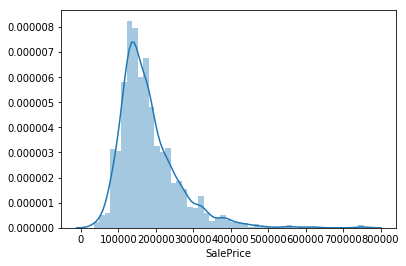

In [12]:
sns.distplot(data['SalePrice'])

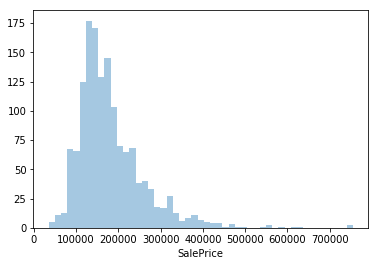

In [17]:
sns.distplot(data['SalePrice'], kde=False)

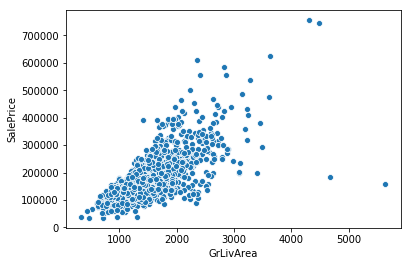

In [13]:
sns.scatterplot(x=data['GrLivArea'], y=data['SalePrice'])

#### By intution the Living Area is a factor that would be affecting the house Saleprice mostly and there seem to be a linear relation between the two

In [22]:
data['SalePrice'].corr(data['GrLivArea'])

0.7086244776126522

0.6135805515591956

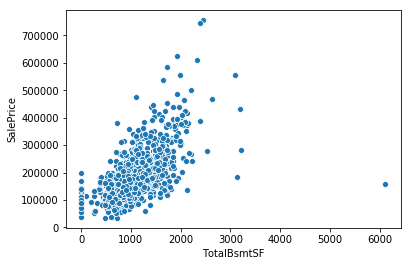

In [13]:
sns.scatterplot(data.TotalBsmtSF, data.SalePrice)
data.SalePrice.corr(data.TotalBsmtSF)

### Now let's see the relation of SalePrice to other parameters

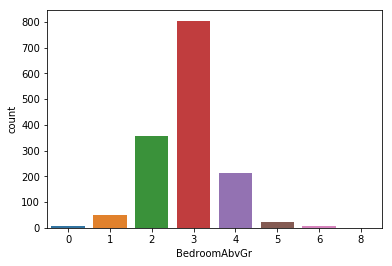

In [23]:
#Count of bedrooms among all the houses
sns.countplot(x=data['BedroomAbvGr'])

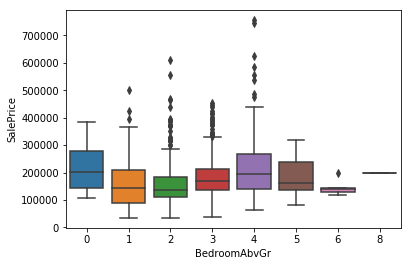

In [26]:
#Lets see the price of house wrt no. of bedrooms
sns.boxplot(data.BedroomAbvGr, data.SalePrice)

Price seem to be independent of No. of bedrooms. Lets check via ANOVA

### ANOVA Hypotheses (Used to find f-value and p for categorical vs. numerical variable)

* Null hypotheses: No relation. Groups means are equal (no variation in means of groups)
* Alternative hypotheses: At least, one group mean is different from other groups

In [30]:
data.groupby('BedroomAbvGr').mean()['SalePrice']

BedroomAbvGr
0    221493.166667
1    173162.420000
2    158197.659218
3    181056.870647
4    220421.253521
5    180819.047619
6    143779.000000
8    200000.000000
Name: SalePrice, dtype: float64

In [56]:
import scipy.stats as stats

f_value, p_value = stats.f_oneway(data.SalePrice[data.BedroomAbvGr == 0],
                                  data.SalePrice[data.BedroomAbvGr == 1],
                                  data.SalePrice[data.BedroomAbvGr == 2],
                                  data.SalePrice[data.BedroomAbvGr == 3],
                                  data.SalePrice[data.BedroomAbvGr == 4],
                                  data.SalePrice[data.BedroomAbvGr == 5],
                                  data.SalePrice[data.BedroomAbvGr == 6],
                                  data.SalePrice[data.BedroomAbvGr == 8])
print(f_value, p_value)

12.92541345911101 3.3043196450461637e-16


Null hypothesis that no relation b/w bedroom# and sale price is rejected i.e. there seem to be a relation, which is more practical. <br><b> i.e. the price of house is dependent on the no. of bedrooms </b>

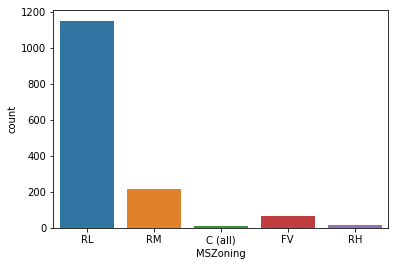

In [28]:
sns.countplot(data.MSZoning)

#### Most of the houses sold are resedential low density

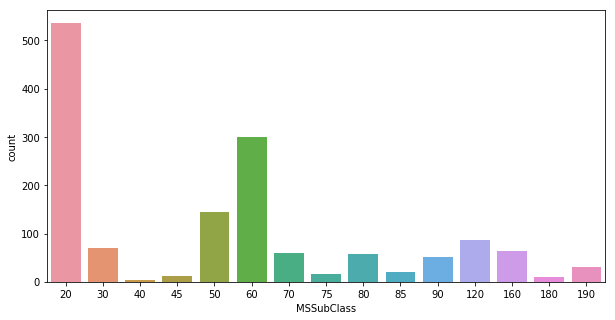

In [38]:
plt.figure(figsize=(10,5))
sns.countplot(data.MSSubClass)

#### Majority are 20	1-STORY 1946 & NEWER ALL STYLES

0.3517990965706781

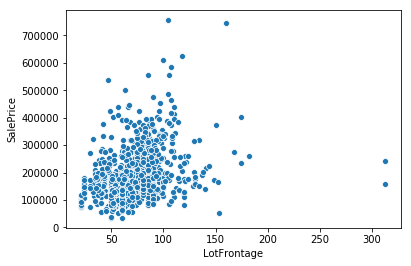

In [40]:
sns.scatterplot(data.LotFrontage, data.SalePrice)
data.SalePrice.corr(data.LotFrontage)

0.26384335387140573

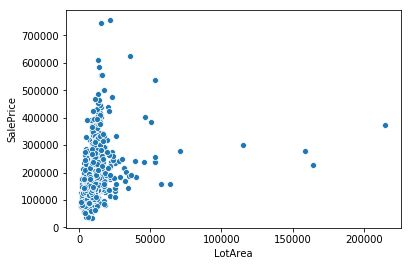

In [41]:
sns.scatterplot(data.LotArea, data.SalePrice)
data.SalePrice.corr(data.LotArea)

#### Much weaker relation of price to lotarea

Street: Type of road access to property 

       * Grvl	Gravel	
       * Pave	Paved

Street
Grvl    130190.500000
Pave    181130.538514
Name: SalePrice, dtype: float64

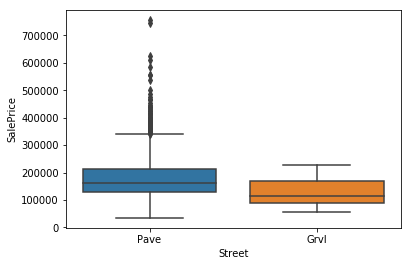

In [43]:
sns.boxplot(data.Street, data.SalePrice)
data.groupby('Street').mean()['SalePrice']

In [44]:
f_value, p_value = stats.f_oneway(data.SalePrice[data.Street == 'Pave'],
                                  data.SalePrice[data.Street == 'Grvl'])
print(f_value, p_value) #ideally, there should be relation i.e. p<0.05

2.4592895583691994 0.11704860406782483


#### Null hypo holds i.e. no evidence that there is price variation based on Street

### Lets see if the type of utilities matter! (ideally should matter)

Utilities
AllPub    180950.95682
NoSeWa    137500.00000
Name: SalePrice, dtype: float64

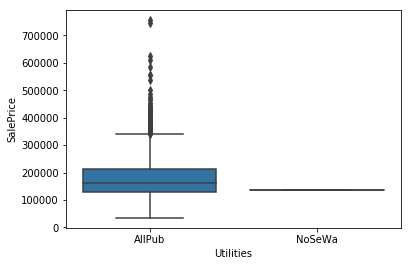

In [45]:
sns.boxplot(data.Utilities, data.SalePrice)
data.groupby(data.Utilities).mean()['SalePrice']

In [47]:
f_value, p_value = stats.f_oneway(data.SalePrice[data.Utilities == 'AllPub'],
                                  data.SalePrice[data.Utilities == 'NoSeWa'])
print(f_value, p_value) #p>0.05, null hypo holds i.e. no relation

0.29880407484898486 0.5847167739689381


### Lets check if Overall Quality of house matters for price

OverallQual
1      50150.000000
2      51770.333333
3      87473.750000
4     108420.655172
5     133523.347607
6     161603.034759
7     207716.423197
8     274735.535714
9     367513.023256
10    438588.388889
Name: SalePrice, dtype: float64

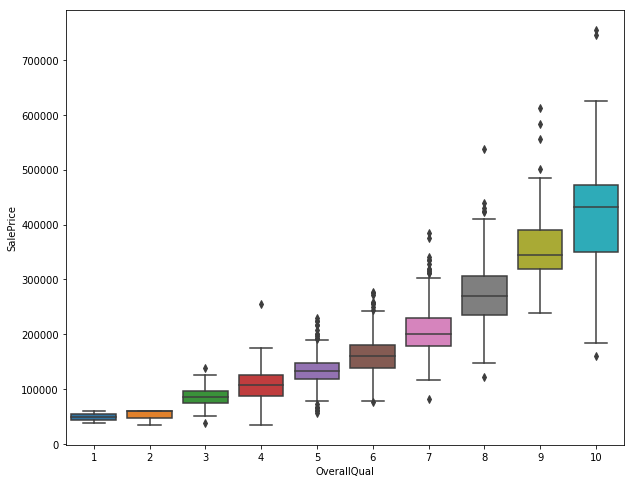

In [14]:
plt.figure(figsize=(10,8))
sns.boxplot(data.OverallQual, data.SalePrice)
data.groupby('OverallQual').mean()['SalePrice']

In [50]:
f_value, p_value = stats.f_oneway(data.SalePrice[data.OverallQual == 1],
                                  data.SalePrice[data.OverallQual == 2],
                                  data.SalePrice[data.OverallQual == 3],
                                  data.SalePrice[data.OverallQual == 4],
                                  data.SalePrice[data.OverallQual == 5],
                                  data.SalePrice[data.OverallQual == 6],
                                  data.SalePrice[data.OverallQual == 7],
                                  data.SalePrice[data.OverallQual == 8],
                                  data.SalePrice[data.OverallQual == 9],
                                  data.SalePrice[data.OverallQual == 10])
print(f_value, p_value) #p<0.05, null hypo rejected i.e. price depends on quality

349.02683956930736 0.0


#### Lets see if garage area would matter 

In [14]:
data.GarageCars.dtypes

dtype('int64')

0.6234314389183617

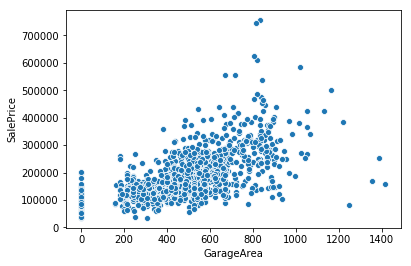

In [19]:
sns.scatterplot(data.GarageArea, data.SalePrice)
data.GarageArea.corr(data.SalePrice)

#### Lets see if the garage cars capacity would matter, generally it should

GarageCars
0    103317.283951
1    128116.688347
2    183851.663835
3    309636.121547
4    192655.800000
Name: SalePrice, dtype: float64

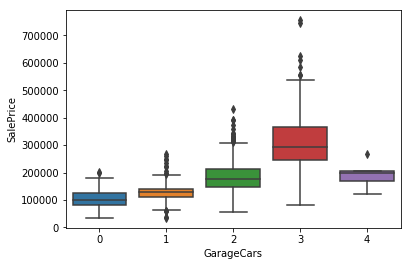

In [54]:
sns.boxplot(data.GarageCars, data.SalePrice)
data.groupby('GarageCars').mean()['SalePrice']

In [58]:
#lets see statistically
f_value, p_value = stats.f_oneway(data.SalePrice[data.GarageCars == 0],
                                  data.SalePrice[data.GarageCars == 1],
                                  data.SalePrice[data.GarageCars == 2],
                                  data.SalePrice[data.GarageCars == 3],
                                  data.SalePrice[data.GarageCars == 4])
print(f_value, p_value)

351.2074862087727 1.1211287650614395e-211


No. of car capacity would affect the price. Null hypo of no relation rejected.

### Finally, lets see the relation of no. of garage car capacity and no. of bedroom, both categorical

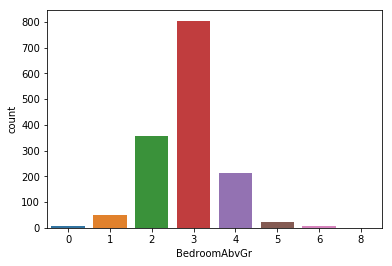

In [61]:
sns.countplot(data.BedroomAbvGr)

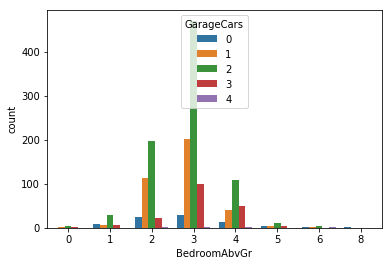

In [60]:
sns.countplot(data.BedroomAbvGr, hue=data.GarageCars)

In [63]:
from scipy.stats import chi2_contingency

crosstab = pd.crosstab(data.BedroomAbvGr, data.GarageCars)
crosstab

GarageCars,0,1,2,3,4
BedroomAbvGr,,,,,
0,0,1,4,1,0
1,8,7,29,6,0
2,24,113,198,22,1
3,29,203,471,99,2
4,14,40,108,50,1
5,3,4,11,3,0
6,2,1,3,0,1
8,1,0,0,0,0


In [65]:
chi2_stat, p_val, dof, ex = chi2_contingency(crosstab)
print(chi2_stat, p_val, dof)

132.15853806997916 1.827820851501137e-15 28


p_value of <0.05 => null hypo of no relation rejected, there is relation. <b>i.e. More bedrooms would imply more car capacity </b>

#### Lets see OverallCond vs. No. of bedroom - generally no relation

In [68]:
crosstab = pd.crosstab(data.OverallCond, data.BedroomAbvGr)
crosstab

BedroomAbvGr,0,1,2,3,4,5,6,8
OverallCond,,,,,,,,
1,0,1,0,0,0,0,0,0
2,0,1,2,1,1,0,0,0
3,0,3,7,7,6,2,0,0
4,1,1,14,24,13,2,2,0
5,3,31,195,462,118,8,4,0
6,1,5,63,149,31,2,1,0
7,0,3,57,112,28,4,0,1
8,0,5,17,38,9,3,0,0
9,1,0,3,11,7,0,0,0


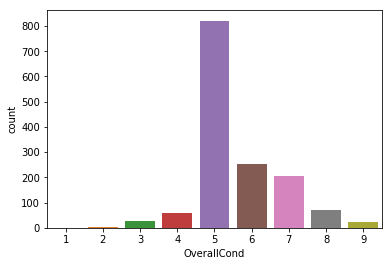

In [69]:
sns.countplot(data.OverallCond)

In [70]:
chi2, p_val, dof, ex = chi2_contingency(crosstab)
print(chi2, p_val) #there is relation

112.91269985351292 1.0260998609996293e-05


### Lets see year sold and no. of bedroom - should generally be no relation

In [71]:
crosstab = pd.crosstab(data.YrSold, data.BedroomAbvGr)
chi2, p_val, dof, ex = chi2_contingency(crosstab)
print(chi2, p_val)

30.522105087107782 0.33870461988416456


Null hypothesis holds, i.e. no relation as expected

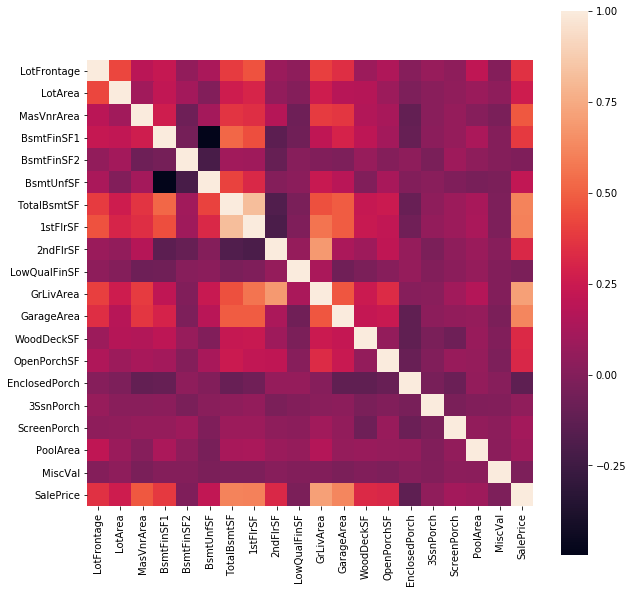

In [46]:
#Get a correlation matrix and heat map

plt.figure(figsize=(10,10))
sns.heatmap(data.corr())

In [25]:
corr = data.corr()
corr[corr['SalePrice'] > 0.4]['SalePrice']

MasVnrArea     0.477493
TotalBsmtSF    0.613581
1stFlrSF       0.605852
GrLivArea      0.708624
GarageArea     0.623431
SalePrice      1.000000
Name: SalePrice, dtype: float64

#### We might need to check multi-collienarity ex. b/w TotalBsmtSF and 1stFlrSF may be correlated

## EDA ends here

### Decission Tree Model

In [134]:
from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(random_state=40)
dtree.fit(X_train, y_train)
predicton = dtree.predict(X_test)

print('RMSE: %d' %np.sqrt(mean_squared_error(y_test, prediction)))
print('R2 Score: %.3f' %r2_score(y_test, prediction))

RMSE: 22583
R2 Score: 0.863


#### This is bad than the linear model, rejected

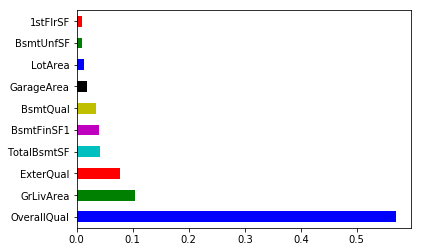

In [135]:
my_colors = ['b','g','r','c','m','y','k']
feat_importantances = pd.Series(dtree.feature_importances_, index=X_train.columns)
feat_importantances.nlargest(10).plot(kind='barh', color=my_colors)
plt.show()

### Random Forest

In [25]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators': np.arange(100, 1201, 100).tolist(),
              'max_features': ['auto', 'sqrt'],
              'max_depth': [5, 10, 15],
              'min_samples_leaf': [1, 2, 5, 10, 20, 50],
              'min_samples_split':[2, 5, 10, 15, 50, 100] }

In [26]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=40)

In [29]:
rf_grid = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=5, 
                             verbose=1, random_state=40, n_jobs=-1)

In [30]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  6.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [31]:
rf_grid.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10}

In [32]:
model = rf_grid.best_estimator_

In [33]:
# Make predictions on the test set
y_pred = (model.predict(X_test))
output = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': y_pred})
output.to_csv('prediction.csv', index=False)

## Xgboost Model

In [34]:
import xgboost

regressor = xgboost.XGBRegressor()

In [35]:
model_grid = {'max_depth':[3, 5, 7, 10, 12, 15],
              'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2],
              'n_estimators': np.arange(100,1501,100).tolist(),
              'booster':['gbtree','gblinear'] }

In [36]:
random_cv = RandomizedSearchCV(estimator=regressor, param_distributions=model_grid, cv=5, n_iter=50,verbose=1,
                              random_state=40, n_jobs=-1)

In [37]:
random_cv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 13.7min finished
C:\Users\mansoorali_baig\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\mansoorali_baig\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:40:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          verbosity=1),
                   iid='deprecated', n_iter=50, n_jobs=-1,
                   param_distributions={'booster': ['gbtree', 'gblinear']

In [38]:
random_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
model = random_cv.best_estimator_

# Make predictions on the test set
y_pred = (model.predict(X_test))
output = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': y_pred})
output.to_csv('prediction.csv', index=False)